<a href="https://colab.research.google.com/github/sankarvinayak/DL-assignment1/blob/main/DL_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 DA6401 Deeplearning
## Sankar Vinayak E P

In [1]:
!pip install wandb
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m041 (cs24m041-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [16]:
import wandb
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import numpy as np


## Question 1
Plot fasion-mnist dataset


In [4]:
wandb.init(project="CS6401")
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

wandb: Currently logged in as: cs24m041 (cs24m041-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

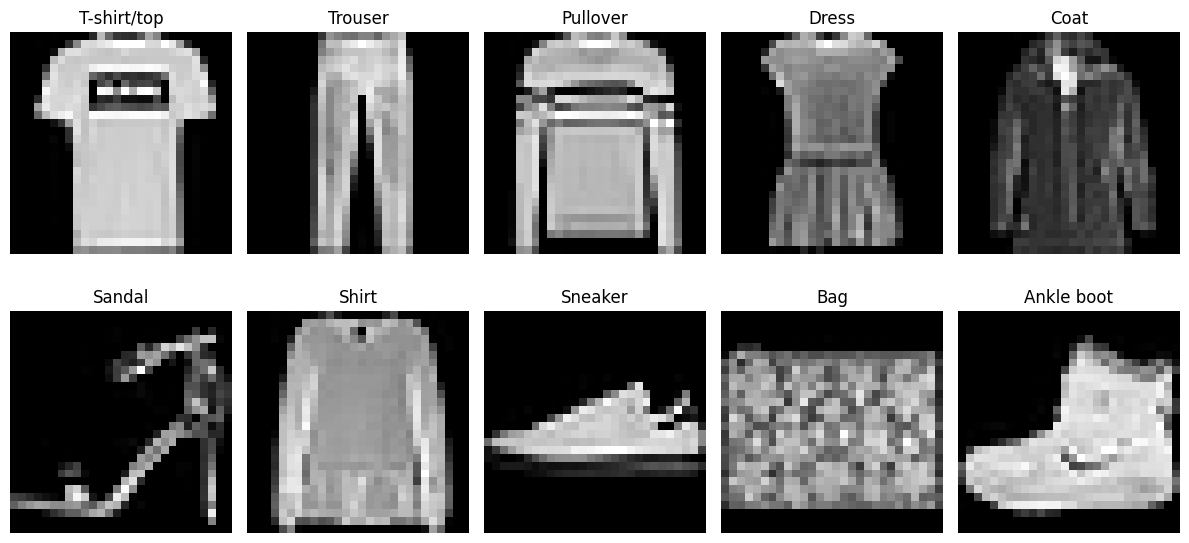

In [8]:
# Define class names (corresponds to the labels 0-9)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

sample_images = {}
for label in range(10):
    idx = next(i for i, l in enumerate(train_labels) if l == label)
    sample_images[label] = train_images[idx]

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.ravel()

for i in range(10):
    axs[i].imshow(sample_images[i], cmap='gray')
    axs[i].set_title(class_names[i])
    axs[i].axis('off')

plt.tight_layout()

wandb.log({"Fashion MNIST Samples": wandb.Image(fig)})

plt.show()

wandb.finish()

## Question 2
Impliment feedforward neural network

#### Actvation functions

In [54]:
from abc import abstractmethod
class ActivationFn:
  @abstractmethod
  def forward(X):
    pass
  @abstractmethod
  def grad():
    pass
class Sigmoid(ActivationFn):
  def forward(self,X):
    return 1/(1+np.exp(-X))
  def grad(self,X):
    fx=self.forward(X)
    return fx*(1-fx)
class Tanh(ActivationFn):
  def forward(self,X):
    return np.tanh(X)
  def grad(self,X):
    return 1-self.forward(X)**2
class ReLU(ActivationFn):
  def forward(self,X):
    return np.maximum(0,X)
  def grad():
    pass
class softmax(ActivationFn):
  def forward(self,X):
    exps=np.exp(X)
    return exps/np.sum(exps,axis=1,keepdims=True)
  def grad():
    pass

#### Loss functions

In [49]:
def MSE(prediction,actual):
  assert prediction.shape == actual.shape, "Shapes of prediction and actual must be the same"
  diff=prediction-actual
  sqr=diff**2
  return np.mean(sqr)
def crossEntropy(prediction,actual):
  return -np.sum(actual*np.log(prediction))

#### Layer

In [55]:
class fc_layer:
  def __init__(self,n_inputs,n_output,activation_fn:ActivationFn=Sigmoid(),initialization="random") :
    if initialization=="Xavier":
      pass
    else:
      self.weights=np.random.randn(n_inputs,n_output)
      self.bias=np.random.randn(1,n_output)
    self.activation_fn=activation_fn
  def forward_pass(self,h_prev):
    self.a_layer=np.dot(h_prev,self.weights)+self.bias
    self.h_this=self.activation_fn.forward(self.a_layer)
    return self.h_this



In [56]:
class Network:
  def __init__(self):
    self.layers=[]

  def append_layer(self,layer:fc_layer):
    self.layers.append(layer)

  def forwad_pass_network(self,X):
    self.input=X
    temp=X
    for layer in self.layers:
      temp=layer.forward_pass(temp)
    Y=temp
    return Y

  def backward_pass(self,Y_hat_set,Y_set):

    grad_aL=-(Y_set-Y_hat_set)
    grad_ak=grad_aL

    for k in reversed(range(len(self.layers))):
      layer=self.layers[k]
      if k==0:
        h_prev=self.input
        grad_Wk=np.outer(grad_ak,h_prev)
        grad_bk=grad_ak
        # grad_h=np.dot(layer.weights.T,grad_ak)
        # grad_ak=grad_h*(layer.activation_fn.grad(self.input))
      else:
        prev=self.layers[k-1]
        h_prev=self.layers[k-1].h_this
        grad_Wk=np.outer(grad_ak,h_prev)
        grad_bk=grad_ak
        grad_h=np.dot(layer.weights.T,grad_ak)
        grad_ak=grad_h*prev.activation_fn.grad(prev.a_layer)


In [57]:
np.random.seed(1)
nn=Network()
fc_layer1=fc_layer(n_inputs=2,n_output=3)
fc_layer2=fc_layer(n_inputs=3,n_output=2,activation_fn=softmax())
nn.append_layer(fc_layer1)
nn.append_layer(fc_layer2)
X=np.array([[1,2],[3,4],[5,6]])
print(X.shape)
Y=nn.forwad_pass_network(X)
print(Y)

(3, 2)
[[0.03609885 0.96390115]
 [0.02390269 0.97609731]
 [0.01849657 0.98150343]]


In [47]:
crossEntropy(Y,np.array([[1,0],[0,1],[0,1]]))

11.045428658370723

## Question 3
Impliment backprop

In [ ]:
def gradient_descent(input,output,max_iter:int,model:Network):
  t=0;
  while t<max_iter:
    Y_hat_set=model.forwad_pass_network(input)
    model.backward_pass(Y_hat_set,output)
    t+=1



### Gradient Descent

### Stochastic Gradient descent

### Moementum based Gradient descent

### Nestrov accelerated gradient descent

### RMSProp

### adam

### nadam

## Question 4
Best hyper parameter value

- number of epochs: 5, 10
- number of hidden layers:  3, 4, 5
- size of every hidden layer:  32, 64, 128
- weight decay (L2 regularisation): 0, 0.0005,  0.5
- learning rate: 1e-3, 1 e-4
- optimizer:  sgd, momentum, nesterov, rmsprop, adam, nadam
- batch size: 16, 32, 64
- weight initialisation: random, Xavier
- activation functions: sigmoid, tanh, ReLU

## Question 5

Best accuracy on validation set across all models

## Question 6

inferences

## Question 7

Model with best accuracy on test set ,
Plot confusion matrix

## Question 8

Compare MSE with cross entropy

## Quetion 9
Link to github:https://github.com/sankarvinayak/DL-assignment1

## Question 10
Recomendation of 3 set of hyperparameter for MNIST